In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# 加载鸢尾花数据集
def load_iris_data():
    """加载鸢尾花数据集并转换为DataFrame格式"""
    iris = load_iris()
    df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
    df['target'] = df['target'].astype(int)
    # 将数字标签转换为类别名称
    target_names = {i: name for i, name in enumerate(iris['target_names'])}
    df['target_name'] = df['target'].map(target_names)
    return df

In [6]:
df = load_iris_data()
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [8]:
# 自定义转换器：提取特征
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.feature_names].values

def reduce_dimension_and_visualize(df, feature_names, target_column, n_components=2, random_state=42):
    """对特征进行降维并可视化"""
    # 提取特征和标签
    X = df[feature_names].values
    y = df[target_column].values

    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=30)
    X_2d = tsne.fit_transform(X_scaled)

    # 创建降维后的DataFrame
    df_2d = pd.DataFrame({
        'x': X_2d[:, 0],
        'y': X_2d[:, 1],
        target_column: y
    })

    # 可视化
    plt.figure(figsize=(10, 8))

    # 按标签绘制散点图
    sns.scatterplot(
        x='x', y='y', hue=target_column, data=df_2d,
        palette='viridis',  # 使用更适合多类别的调色板
        s=50, alpha=0.8
    )

    plt.title('t-SNE降维可视化', fontsize=15)
    plt.xlabel('t-SNE 维度1', fontsize=12)
    plt.ylabel('t-SNE 维度2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='类别')
    plt.tight_layout()

    return df_2d, X_scaled, y

# 自定义分类器选择器
class ClassifierSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=SVC()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

def train_and_compare_models(X, y, test_size=0.3, random_state=42):
    """训练并比较SVC和LightGBM模型"""
    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # 创建管道
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', ClassifierSelector())
    ])

    # 定义超参数网格
    param_grid = [
        # SVC参数网格
        {
            'classifier__estimator': [SVC(probability=True, random_state=random_state)],
            'classifier__estimator__C': [0.1, 1, 10, 100],
            'classifier__estimator__kernel': ['linear', 'rbf'],
            'classifier__estimator__gamma': ['scale', 'auto', 0.01, 0.1]
        },
        # LightGBM参数网格
        {
            'classifier__estimator': [lgb.LGBMClassifier(random_state=random_state)],
            'classifier__estimator__n_estimators': [50, 100, 200],
            'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],
            'classifier__estimator__max_depth': [-1, 3, 5, 7],
            'classifier__estimator__num_leaves': [31, 50, 100]
        }
    ]

    # 使用网格搜索找到最佳参数
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
    )  # scoring='f1_macro', score='f1_'

    # 训练模型
    print("开始训练模型...")
    grid_search.fit(X_train, y_train)

    # 输出最佳参数
    print(f"最佳模型: {grid_search.best_params_['classifier__estimator']}")
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")

    # 在测试集上评估模型
    y_pred = grid_search.predict(X_test)

    # 打印分类报告
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))

    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)

    return grid_search.best_estimator_, y_test, y_pred, cm

def plot_confusion_matrix(cm, classes, title='混淆矩阵'):
    """绘制混淆矩阵"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title, fontsize=14)
    plt.ylabel('真实标签', fontsize=12)
    plt.xlabel('预测标签', fontsize=12)
    plt.tight_layout()

C:\Users\xuhao\.conda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xuhao\.conda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:48: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:48: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:48: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:48: UserWarning: Glyph 21487 (\N{CJK 

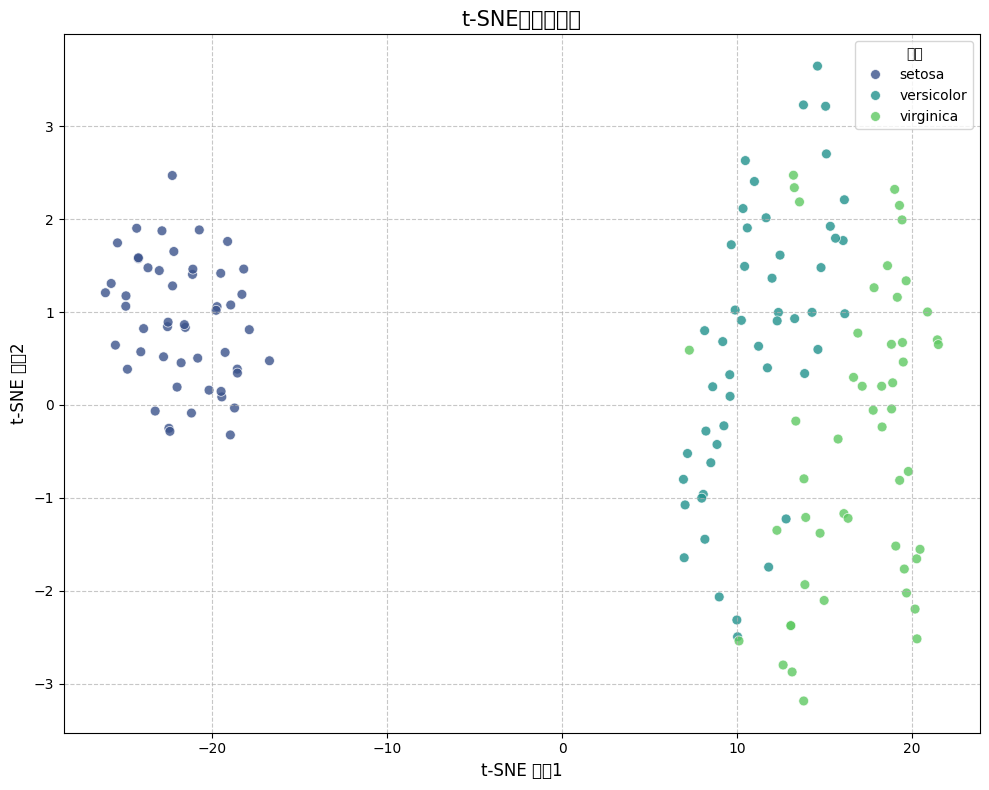

In [9]:
# 特征名称
feature_names = ['sepal length (cm)', 'sepal width (cm)', 
                 'petal length (cm)', 'petal width (cm)']

# 降维并可视化
df_2d, X_scaled, y = reduce_dimension_and_visualize(df, feature_names, 'target_name')

In [10]:
# 训练模型并比较
best_model, y_test, y_pred, cm = train_and_compare_models(X_scaled, y)

开始训练模型...
Fitting 5 folds for each of 140 candidates, totalling 700 fits
最佳模型: SVC(C=0.1, kernel='linear', probability=True, random_state=42)
最佳参数: {'classifier__estimator': SVC(C=0.1, kernel='linear', probability=True, random_state=42), 'classifier__estimator__C': 0.1, 'classifier__estimator__gamma': 'scale', 'classifier__estimator__kernel': 'linear'}
最佳交叉验证准确率: 0.9905

分类报告:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
C:\Users\xuhao\AppData\Local\Temp\ipykernel_19324\3367384768.py:141: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}

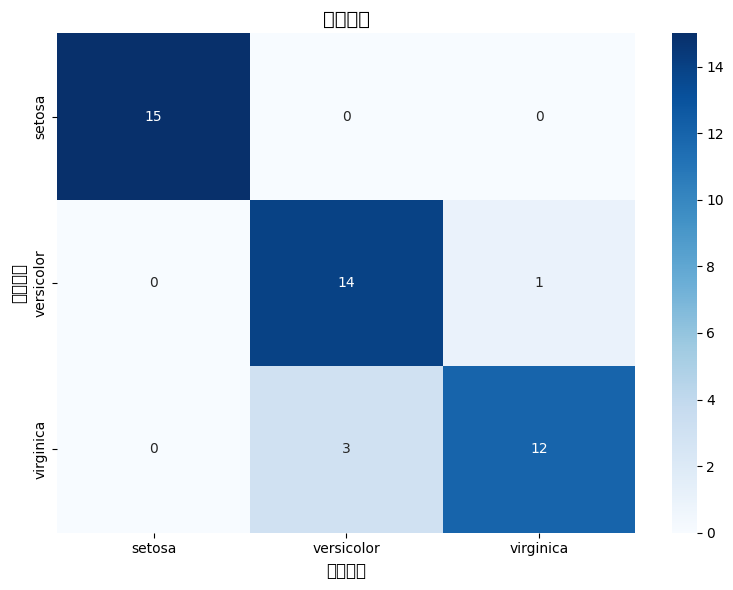

In [11]:
# 可视化混淆矩阵
plot_confusion_matrix(cm, classes=np.unique(y))